<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# Practicum Project: Bincentive

## Pairtrading: Version 0409 ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Only Using Crypto

## Basic Import

In [2]:
import os
import ccxt
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import warnings 
warnings.filterwarnings('ignore')
import itertools

## Basic Defination 

In [77]:
def Delete_all_CSV(i):
    pngfiles = [f for f in os.listdir(i) if f.endswith(".csv")]
    print("existing png files: " + str(pngfiles))
    [os.remove(i + f) for f in pngfiles]
    print("All csv removed.")
    print("------------------------------------------------------")


def saver(fname):
    plt.savefig(fname + ".png", bbox_inches="tight")


def generate_result(model, y, y_pred, timestamp):
    #Kill Previous Result

    # First Generate Plot
    r2 = R2(y, y_pred)
    mse = MSE(y, y_pred)
    mape = MAPE(y, y_pred)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(timestamp, y, color='navy', label="BTC/USDT")
    ax.plot(timestamp, y_pred, color="orange", label='fitted value')

    ax.set_title(model)
    ax.set_ylabel("Normalized Prices")
    ax.set_xlabel("Date")

    table_data = [["R2", r2], ["MSE", mse], ["MAPE", mape]]
    table = ax.table(cellText=table_data,
                     cellLoc="center",
                     colWidths=[0.5, 1.5],
                     colLabels=['Index', 'Result'],
                     loc="center",
                     bbox=[0, -0.5, 1, 0.3])
    table.set_fontsize(10)

    # Place the legend outside the plot to the right
    ax.legend()

    #saver('/Users/yu-chingliao/Desktop/untitled folder/'+symbol_1.replace("/", "_")+" vs "+symbol_2.replace("/", "_"))
    #plt.close()
    plt.show()
    print("Task Complete. ")

def moving_average(Xt, window_size):
    return np.convolve(Xt, np.ones(window_size), 'valid') / window_size

## Fetching Data

In [3]:
# Initialize the Coinbase Pro exchange object
exchange = ccxt.coinbasepro({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

# Function to fetch historical data
def fetch_historical_data(exchange, symbol, timeframe, since, until):
    data = []
    while since < until:
        chunk = exchange.fetch_ohlcv(symbol, timeframe, since)
        if not chunk:
            break
        since = chunk[-1][0] + 1  # Move to the next timestamp
        data += chunk
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['rate_of_return'] = df['close'].pct_change()
    return df

Delete_all_CSV('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/')

correlated_pairs = [
    'BTC/USDT',
    'ETH/USDT',
    'ADA/USDT',
    'DOGE/USDT',
    'SOL/USDT',
    'DOT/USDT',
    'LINK/USDT',
    'XLM/USDT',
    'EOS/USDT',
    'XMR/USDT',
    'TRX/USDT'
]



since = exchange.parse8601('2022-03-28T00:00:00Z')
until = exchange.parse8601('2023-03-27T23:00:00Z')

# Load the supported pairs for Coinbase Pro
exchange.load_markets()

# Filter the correlated pairs list based on the supported pairs in Coinbase Pro
supported_correlated_pairs = [
    pair for pair in correlated_pairs if pair in exchange.markets
]

print("Supported correlated pairs in Coinbase Pro:", supported_correlated_pairs)

#Fetching 
for pairs in  supported_correlated_pairs: 

    # Define the trading pairs, timeframe, and dates
    symbol_1= pairs
    timeframe = '1h'  # 1-hour candles


    # Fetch historical data for the pairs
    df1 = fetch_historical_data(exchange, symbol_1, timeframe, since, until)

    # Save the data to CSV files
    df1.to_csv('/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/'
               +symbol_1.replace("/", "_")+'_historical_data.csv', index=False)

    print(f'Fetched historical data for {symbol_1} since {datetime.utcfromtimestamp(since / 1000).strftime("%Y-%m-%d")}.')


existing png files: ['XLM_USDT_historical_data.csv', 'BTC_USDT_historical_data.csv', 'DOGE_USDT_historical_data.csv', 'ETH_USDT_historical_data.csv', 'LINK_USDT_historical_data.csv', 'DOT_USDT_historical_data.csv', 'ADA_USDT_historical_data.csv', 'SOL_USDT_historical_data.csv']
All csv removed.
------------------------------------------------------
Supported correlated pairs in Coinbase Pro: ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOGE/USDT', 'SOL/USDT', 'DOT/USDT', 'LINK/USDT', 'XLM/USDT']
Fetched historical data for BTC/USDT since 2022-03-28.
Fetched historical data for ETH/USDT since 2022-03-28.
Fetched historical data for ADA/USDT since 2022-03-28.
Fetched historical data for DOGE/USDT since 2022-03-28.
Fetched historical data for SOL/USDT since 2022-03-28.
Fetched historical data for DOT/USDT since 2022-03-28.
Fetched historical data for LINK/USDT since 2022-03-28.
Fetched historical data for XLM/USDT since 2022-03-28.


## Preprocessing

In [35]:
# Set the directory path
directory_path = "/Users/yu-chingliao/Desktop/Bincentive Practicum/model 1/"

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]

# Load the rate of return data for each cryptocurrency from each CSV file and merge into one DataFrame
df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    temp_df = pd.read_csv(file_path, index_col = "timestamp", parse_dates = ["timestamp"])
    temp_df = temp_df["close"].rename(file[:-20]+"_price")
    if df.empty:
        df = temp_df
    else:
        df = pd.merge(df, temp_df, on="timestamp")
df = df.iloc[1:]

#scaler = StandardScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


# Set the BTC/USDT rate of return as the target variable
target_col = "BTC_USDT_price"

# Set the remaining rate of return columns as the predictor variables
predictor_cols = [col for col in df.columns if col != target_col]

# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

In [36]:
train_df

,XLM_USDT_price,BTC_USDT_price,DOGE_USDT_price,ETH_USDT_price,LINK_USDT_price,DOT_USDT_price,ADA_USDT_price,SOL_USDT_price
timestamp,,,,,,,,
2022-03-28 01:00:00,0.2303,46830.23,0.1462,3292.60,16.70,22.46,1.168,106.10
2022-03-28 02:00:00,0.2311,46937.06,0.1482,3300.21,16.73,22.60,1.174,106.59
2022-03-28 03:00:00,0.2335,47038.88,0.1488,3312.02,16.78,22.95,1.182,106.82
2022-03-28 04:00:00,0.2334,47100.47,0.1496,3318.77,16.89,22.86,1.182,107.08
2022-03-28 05:00:00,0.2333,47072.95,0.1503,3324.25,17.09,22.98,1.197,111.16
...,...,...,...,...,...,...,...,...
2023-01-15 09:00:00,0.0858,20752.98,0.0839,1532.69,6.66,5.88,0.344,22.65
2023-01-15 10:00:00,0.0858,20731.44,0.0840,1531.78,6.66,5.91,0.344,22.69
2023-01-15 11:00:00,0.0863,20727.25,0.0845,1533.37,6.68,5.93,0.346,22.86


## Linear Regression

Learned coefficients: [ 1.26202115e+05  2.30609282e+04  6.49474491e+00 -1.46611349e+03
  8.39449400e+02  8.30563741e+03 -9.42530368e+01]


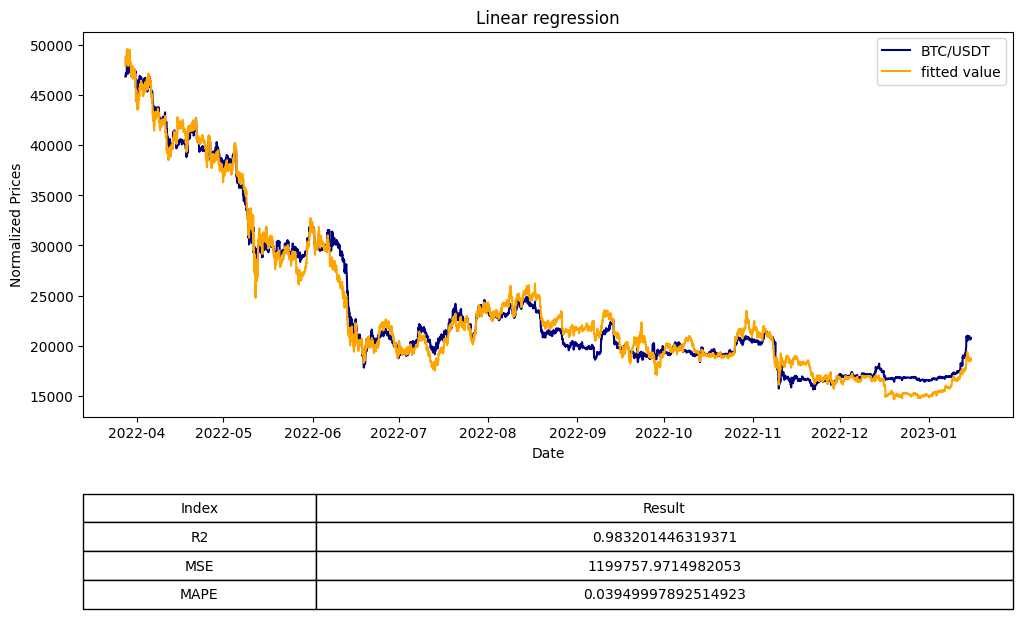

Task Complete. 


In [37]:
linreg_model = LinearRegression(fit_intercept=False)

linreg_model.fit(train_df[predictor_cols], train_df[target_col])
train_df["Fitted Value"] = linreg_model.predict(train_df[predictor_cols])
test_df["Fitted Value"] = linreg_model.predict(test_df[predictor_cols])

print("Learned coefficients:",linreg_model.coef_)
generate_result("Linear regression", 
                train_df[target_col], 
                train_df["Fitted Value"], 
                train_df.index)

In [51]:
train_df["Xt"] = np.log(train_df[target_col]) - np.log(train_df["Fitted Value"])

In [105]:
train_df[train_df.columns[-2:]].head(30)

,Fitted Value,Xt
timestamp,,
2022-03-28 01:00:00,47891.127485,-0.022401
2022-03-28 02:00:00,48164.825391,-0.025821
2022-03-28 03:00:00,48823.518478,-0.037238
2022-03-28 04:00:00,48611.857818,-0.031585
2022-03-28 05:00:00,48198.514859,-0.023630
2022-03-28 06:00:00,48200.733602,-0.026921
2022-03-28 07:00:00,48125.525351,-0.024457
2022-03-28 08:00:00,48300.152535,-0.026737
2022-03-28 09:00:00,48265.713226,-0.023565


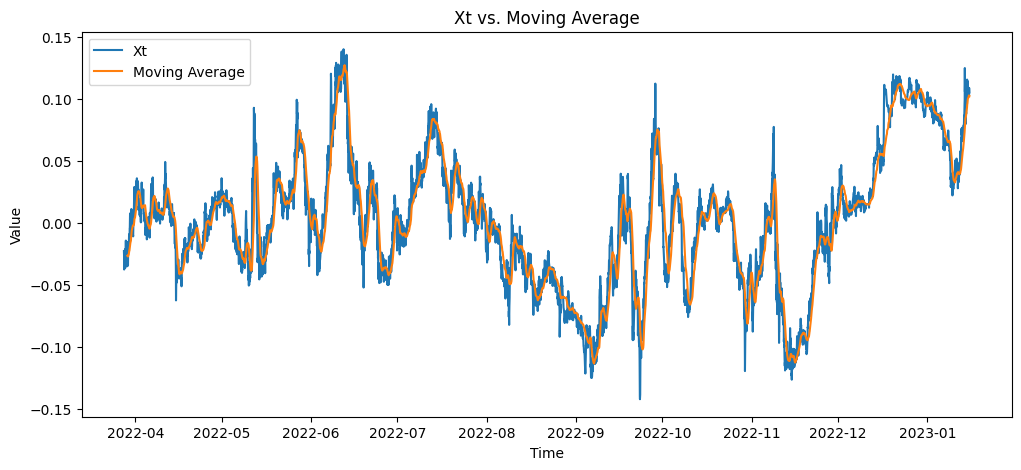

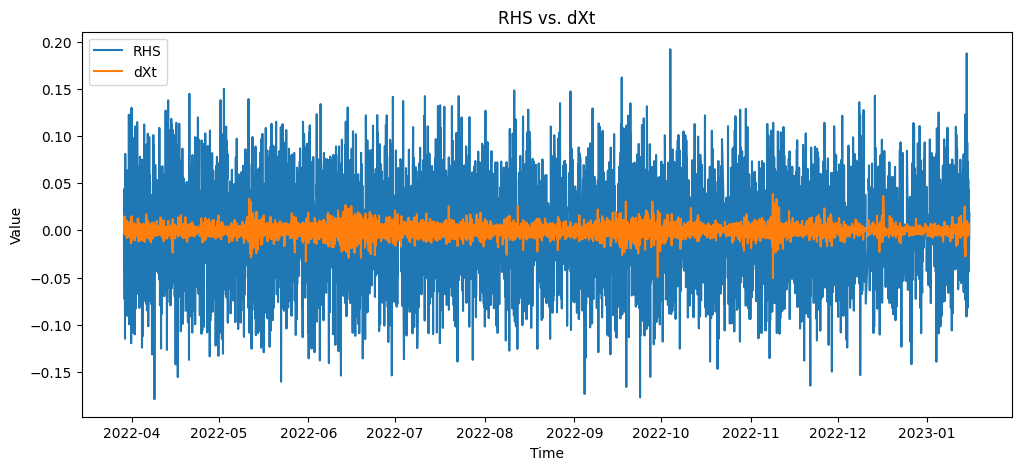

In [113]:
Xt = train_df["Xt"]
η = np.std(train_df["Xt"])
α = moving_average(train_df["Xt"], 30)
dXt = np.roll(Xt, -1)[:-1] - Xt[:-1]
dXt = dXt[29:]
RHS = -α*Xt[29:]*1/24+η*np.random.normal(0, 1, len(Xt[29:]))


plt.figure(figsize=(12, 5))
plt.title( "Xt vs. Moving Average")
plt.plot(train_df["Xt"], label="Xt")
ma = moving_average(train_df["Xt"], 30)
plt.plot(train_df.index[29:], ma, label="Moving Average")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.title("RHS vs. dXt")
plt.plot(RHS, label="RHS")
plt.plot(dXt, label="dXt")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()